In [1]:
import time
import os
import sys

import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats, wcs
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.coordinates import SkyCoord

from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT
import poppy
import photutils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("/Users/tim/src/cwfs/python")
%cd /Users/tim/MMT/61_inch/20181219/

/Users/tim/MMT/61_inch/20181219


In [4]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [ ]:
extra_whole = fits.open("rts2focus0012.fits")[1].data # focus = 3190
intra_whole = fits.open("rts2focus0017.fits")[1].data # focus = 1992
#intra = intra_whole[942-18:942+18,158-18:158+18] - np.median(intra_whole)
#extra = extra_whole[945-18:945+18,154-18:154+18] - np.median(extra_whole)
intra = intra_whole[780-35:780+35,503-35:503+35] - np.median(intra_whole)
extra = extra_whole[780-35:780+35,509-35:509+35] - np.median(extra_whole)

In [ ]:
#plt.imshow(intra_whole[942-20:942+20,158-20:158+20], origin="lower")
#plt.imshow(extra_whole[945-20:945+20,154-20:154+20], origin="lower")
plt.imshow(intra, origin="lower")
plt.show()

In [ ]:
plt.imshow(extra, origin="lower")
plt.show()

In [ ]:
fits.writeto("intra.fits", intra, overwrite=True)
fits.writeto("extra.fits", extra, overwrite=True)

These images are binned 3x3 so the pixels are 42 um. Thus the pupil diameter is:

In [ ]:
pupsize = 25.25 * 3 * 14
pupsize * u.um

The mirror diameter is 1.54 meters and the focal ratio is 13.5. So the focal length is:

In [ ]:
diameter = 1.54 * u.m
m1_radius = diameter / 2.
focal_length = diameter * 13.5
focal_length

Calculate the angle of beam convergence:

In [ ]:
ang = np.arctan2(m1_radius, focal_length)
ang

In [ ]:
offset = pupsize / np.tan(ang) * u.um
offset

In [ ]:
def kuiper_focus(pup_rad, focus, binning=3, direction='out'):
    pupsize = 14 * binning * pup_rad * u.um
    diameter = 1.54 * u.m
    radius = diameter / 2
    focal_length = diameter * 13.5
    beam_ang = np.arctan2(radius, focal_length)
    offset = pupsize / np.tan(beam_ang) * u.um
    counts_per_um = 600. / 28633.5  # empirically determined
    correction = offset.value * counts_per_um
    if 'out' in direction:
        correction *= -1
    return focus + correction

In [ ]:
kuiper_focus(25.25, 3190, direction='out')

So about 14 mm of focus offset at focal plane for 300 counts of focus change which gives 20 counts/mm. For motion at the secondary, scale by the ratio of the squares of the focal ratios:

In [ ]:
counts_per_mm = 600. / offset.to(u.mm).value
counts_per_mm_m2 = counts_per_mm / (13.5**2 / 4.**2)
counts_per_mm, counts_per_mm_m2

In [ ]:
obscuration = 0.4096 / 1.54
obscuration

In [ ]:
nmperrad = m1_radius.to(u.nm).value
nmperasec = nmperrad / 206265.
nmperasec

In [ ]:
fieldXY = [0., 0.]
I1 = Image(readFile("intra.fits"), fieldXY, Image.INTRA)
I2 = Image(readFile("extra.fits"), fieldXY, Image.EXTRA)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(I2.image, origin='lower', cmap='RdBu')
cbar = fig.colorbar(im)
fig.show()

In [ ]:
kuiper = Instrument('61inch', I1.sizeinPix)

In [ ]:
#kuiper.offset = offset.to(u.m).value  # needs to be focus offset between intra and extra positions
kuiper.offset

In [ ]:
algo = Algorithm('exp', kuiper, 3)

In [ ]:
algo.runIt(kuiper, I1, I2, 'onAxis')

In [ ]:
print(algo.zer4UpNm)

In [ ]:
plots.plotZer(algo.zer4UpNm, 'nm')

In [ ]:
zv = ZernikeVector()
zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
zv.denormalize()
zv

In [ ]:
zv.fringe_bar_chart().show()
plt.show()

In [ ]:
plots.plotImage(algo.Wconverge, "Final wavefront", show=True)

In [ ]:
plt.imshow(algo.image)
plt.show()

Scaling seems wrong so try to calculate offset for MMT same way...

In [ ]:
pupsize = 135. * 26.
mmt_diameter = 6.5 * u.m
mmt_radius = diameter / 2.
mmt_focal_length = mmt_diameter * 5.3
ang = np.arctan2(mmt_radius, mmt_focal_length)
mmt_offset = 0.5 * pupsize / np.tan(ang) * u.um
mmt_offset

OK, this matches what we're using there.

Use the Z04 term from the CWFS fit and see if we can calculate a focus correction

In [ ]:
# this calculates the difference in size between in-focus pupil and observed in um
foc_err = (zv['Z04'] / (nmperasec * u.nm / u.arcsec)) * (100 * u.um / u.arcsec)

# use the tangent of the beam angle to convert pupil size difference to shift in focus position at focal plane.
# convert to focus counts and negate to create correction to send to telescope.
foc_corr = -counts_per_mm * foc_err.to(u.mm).value / np.tan(ang)
foc_corr

In [73]:
hdulist_ex = fits.open("rts2focus0012.fits")
hdulist_in = fits.open("rts2focus0017.fits")
hdulist = hdulist_ex

In [74]:
h = hdulist[0].header
h['EPOCH'] = float(h['EPOCH'])
h['EQUINOX'] = float(h['EQUINOX'])
w1 = wcs.WCS(hdulist[1].header)
w2 = wcs.WCS(hdulist[2].header)

In [ ]:
w1

In [ ]:
w2

In [ ]:
hdulist.info()

<IPython.core.display.Javascript object>


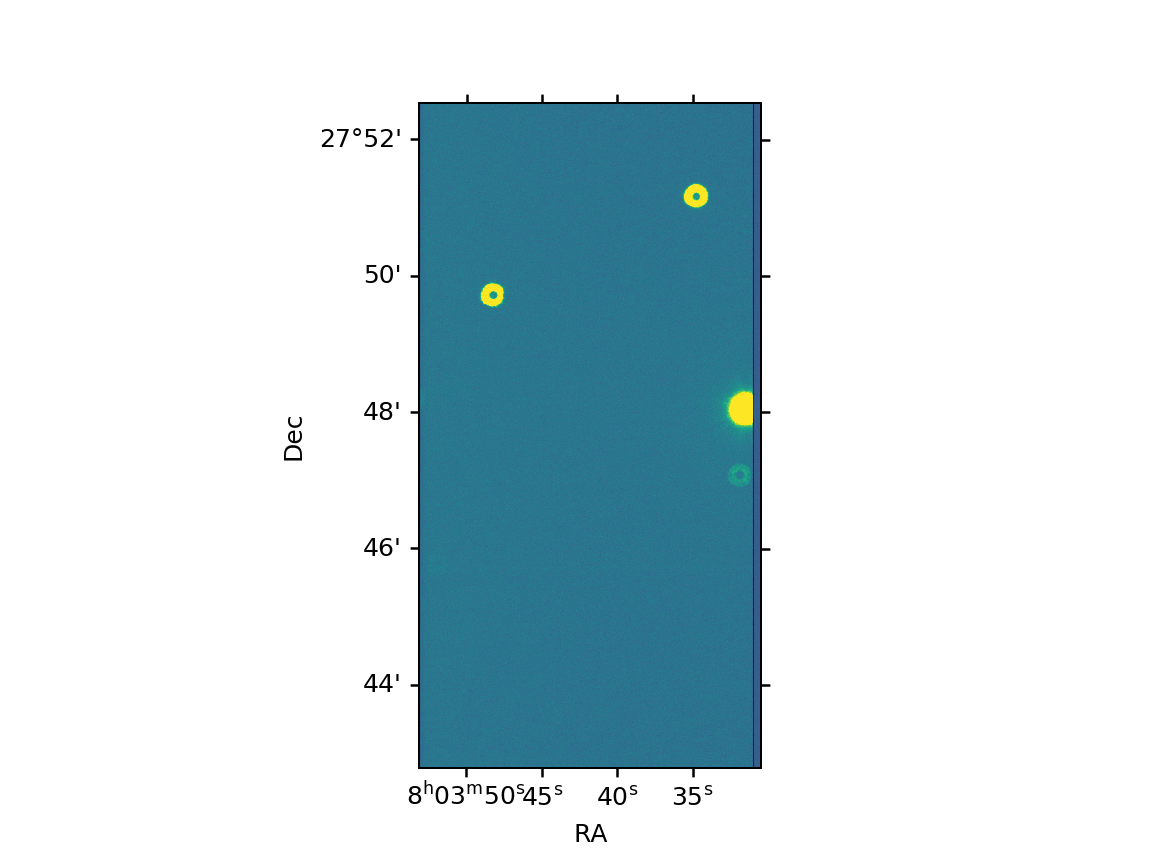

In [80]:
hdu = hdulist[2]
w = wcs.WCS(hdu.header)
im = hdu.data
norm = wfs_norm(im)
plt.subplot(projection=w)
plt.imshow(im, origin='lower', norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [ ]:
threshold = photutils.detect_threshold(im, snr=2)
sigma = 10 * stats.gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=15, y_size=15)
kernel.normalize()
segm = photutils.detect_sources(im, threshold, npixels=25, filter_kernel=kernel)

In [ ]:
plt.imshow(segm, origin='lower', cmap=segm.cmap(random_state=12345))
plt.show()

In [ ]:
cat = photutils.source_properties(im, segm, wcs=w)

In [ ]:
cat.to_table()

In [ ]:
cat[0]['sky_centroid']

In [ ]:
def find_donuts(extra_fits, intra_fits, snr=2, fwhm=10, ksize=15):
    threshold = photutils.detect_threshold(im, snr=snr)
    sigma = fwhm * stats.gaussian_fwhm_to_sigma
    kernel = Gaussian2DKernel(sigma, x_size=ksize, y_size=ksize)
    kernel.normalize()
    hdulist_ex = fits.open("extra.fits")
    hdulist_in = fits.open("intra.fits")
    images = {}
    for foc in ['intra', 'extra']:
        images[foc] = {}
    images['extra']['left'] = hdulist_ex[1]
    images['extra']['right'] = hdulist_ex[2]
    images['intra']['left'] = hdulist_in[1]
    images['intra']['right'] = hdulist_in[2]

In [88]:
from astropy.nddata import CCDData
import ccdproc

In [ ]:
ddd = CCDData.read("rts2focus0001.fits")

In [ ]:
ddd.header

In [169]:
from artnfocus.imutils import ARTNreduce, sub_background

In [180]:
ims = ARTNreduce("rts2focus0001.fits")

In [181]:
#clean = ccdproc.cosmicray_lacosmic(ims, fsmode="convolve", psffwhm=15., sigclip=5)
clean = ims
clean.data = sub_background(ims)

<IPython.core.display.Javascript object>


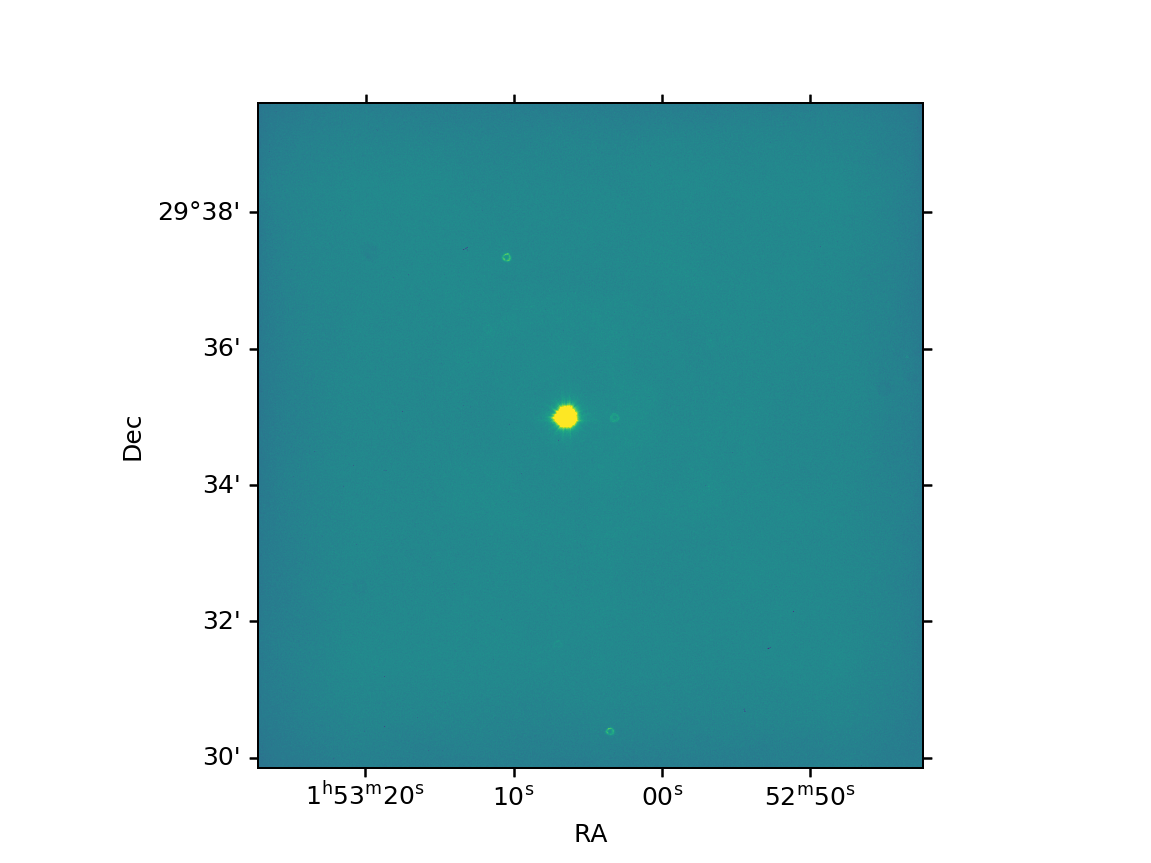

In [182]:
norm = wfs_norm(clean.data)
plt.subplot(projection=clean.wcs)
plt.imshow(clean, norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [183]:
ims.write("blah.fits", overwrite=True)

In [152]:
1364/50

27.28

In [184]:
type(np.ndarray)

type